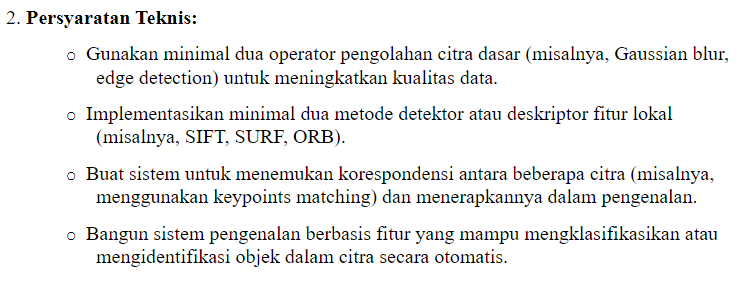

In [2]:
import cv2, os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow
import pytesseract

In [3]:
def bgr2rgb(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

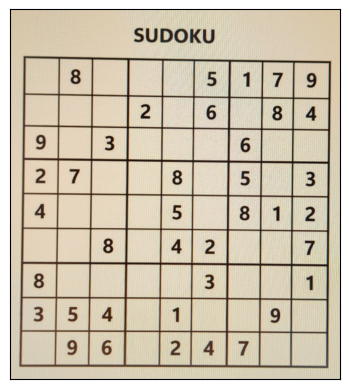

In [4]:
# FILE_PATH ='./dummy_input/Screenshot 2024-12-06 212932.png'
FILE_PATH = './dummy_input/PH_LINK1.jpg'
# FILE_PATH = './dummy_input/sudoku_grid_ex3.jpg'
# FILE_PATH = './dummy_input/wacky grid 3.png'
# FILE_PATH = './dummy_input/wacky grid 2.jpg'
# FILE_PATH = './dummy_input/wacky grid 1.jpg'
image = cv2.imread(FILE_PATH)
# image = cv2.resize(image, (1000, 1000))
plt.imshow(bgr2rgb(image))
plt.xticks([])
plt.yticks([])
plt.show() 

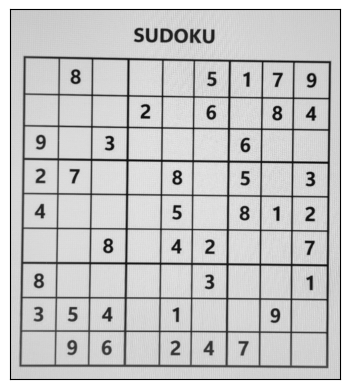

In [5]:
# Grayscale Sudoku Image
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show() 

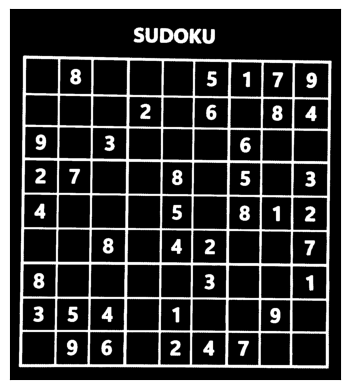

In [6]:
# Blur it and then make it Black n White
blur_gray_image = cv2.GaussianBlur(gray_image, (5, 5), 1)
# _, thresh_image = cv2.threshold(blur_gray_image, 180, 255, cv2.THRESH_BINARY_INV)
thresh_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 7)
plt.imshow(thresh_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show() 

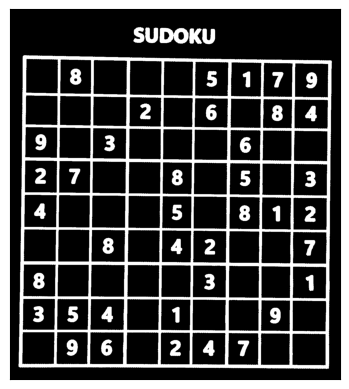

In [7]:
# make the line thicker
kernel = np.array([[0, 1, 0],
                   [1, 1, 1],
                   [0, 1, 0]], dtype=np.uint8)

dilated_image = cv2.dilate(thresh_image, kernel, iterations=1)
plt.imshow(dilated_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

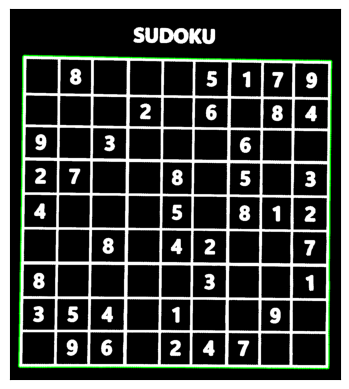

In [8]:
# Detect the rectangle which is where the grid is
contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

largest_contour = max(contours, key=cv2.contourArea)

contour_image = cv2.cvtColor(dilated_image, cv2.COLOR_GRAY2BGR)  
cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 3) 

plt.imshow(contour_image)
plt.xticks([])
plt.yticks([])
plt.show()

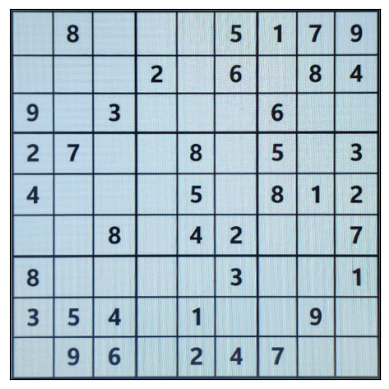

In [9]:
# Fix the perspective of the image
epsilon = 0.02 * cv2.arcLength(largest_contour, True)
approx = cv2.approxPolyDP(largest_contour, epsilon, True)

pts = approx.reshape(4, 2)

rect = np.zeros((4, 2), dtype="float32")
s = pts.sum(axis=1)
rect[0] = pts[np.argmin(s)]  
rect[2] = pts[np.argmax(s)]  
diff = np.diff(pts, axis=1)
rect[1] = pts[np.argmin(diff)]  
rect[3] = pts[np.argmax(diff)] 

width = 450  
height = 450  
dst = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype="float32")

M = cv2.getPerspectiveTransform(rect, dst)
warped_image = cv2.warpPerspective(image, M, (width, height))

plt.imshow(warped_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

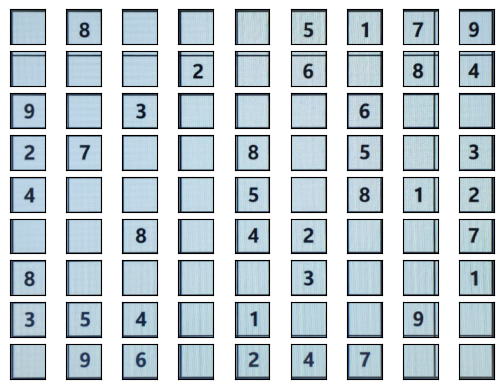

In [10]:
# Split it into 81 image where's each image contain 1 cell from the grid
def splitBoxes(img):
    rows = np.vsplit(img,9)
    boxes=[]
    for r in rows:
        cols= np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes

boxes = splitBoxes(warped_image)

for i in range(len(boxes)):
    plt.subplot(9, 9, i + 1)
    plt.imshow(boxes[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

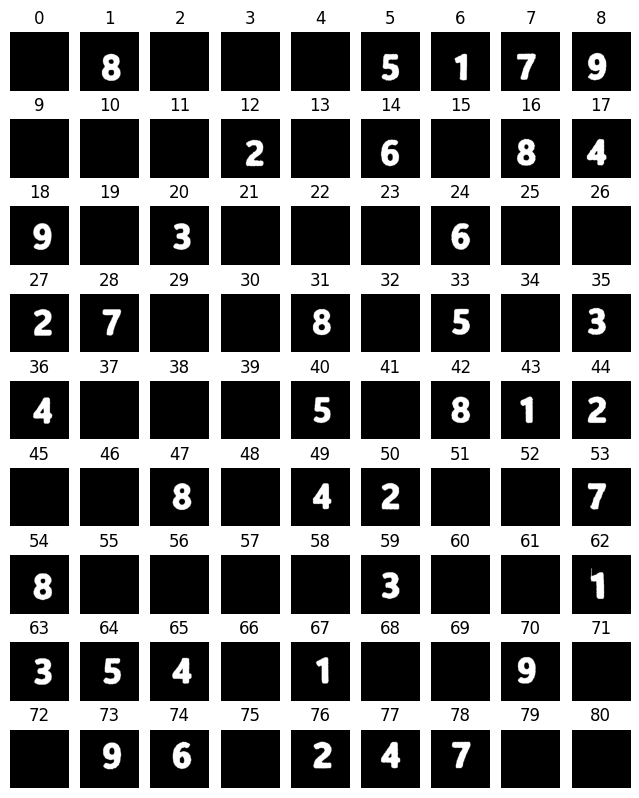

In [ ]:
# Define parameters for filtering
MIN_SIZE = 1000    # Minimum size of a component to consider it valid (adjust as needed)
MAX_SIZE = 90000   # Maximum size to filter out noise (adjust as needed)
EDGE_THRESHOLD = 3  # Minimum distance from edges to consider a component (adjust as needed)
w, h = 300, 300 # w and height of the image
processed_boxes = []

for i in range(len(boxes)):
    target_image = boxes[i]

    # Convert the image to grayscale
    gray_target = cv2.cvtColor(target_image, cv2.COLOR_BGR2GRAY)
    gray_target = cv2.resize(gray_target, (w, h))

    # Step 1: Threshold the image to create a binary image
    _, binary_image = cv2.threshold(gray_target, 180, 255, cv2.THRESH_BINARY_INV)

    # Step 2: Find connected components
    num_labels, labels_im = cv2.connectedComponents(binary_image)

    # Step 3: Initialize variables to find the best component
    best_component = None  # Initialize as None
    best_size = 0
    height, width = gray_target.shape
    center_y, center_x = height // 2, width // 2  # Calculate the center of the image

    # Step 4: Loop through each component
    for label in range(1, num_labels):  # Start from 1 to skip the background
        component_mask = (labels_im == label).astype(np.uint8)  # Create a mask for the component
        size = np.sum(component_mask)  # Count the number of pixels in the component

        # Calculate the bounding box of the component
        y_indices, x_indices = np.where(component_mask > 0)
        if len(y_indices) == 0 or len(x_indices) == 0:
            continue  # Skip if there are no pixels in the component

        # Get the bounding box coordinates
        min_y, max_y = np.min(y_indices), np.max(y_indices)
        min_x, max_x = np.min(x_indices), np.max(x_indices)

        # Check if the component meets size and edge proximity criteria
        if (MIN_SIZE <= size <= MAX_SIZE and
            min_y > EDGE_THRESHOLD and max_y < height - EDGE_THRESHOLD and
            min_x > EDGE_THRESHOLD and max_x < width - EDGE_THRESHOLD):
            
            # Check if this is the best component found based on size
            if size > best_size:
                best_size = size
                best_component = component_mask  # Assign the mask to best_component

    # Step 5: Create a mask for the best component
    if best_component is not None:  # Check if a component was found
        mask = best_component.astype(np.uint8) * 255  # Convert to uint8 for masking

        # Step 6: Use the mask to create an output image where the digit is white and the background is black
        output_image = np.zeros_like(gray_target)  # Create a black image
        output_image[mask > 0] = 255  # Set the pixels of the digit to white

        processed_boxes.append(output_image)  # Store the processed image
    else:
        # If no component was found, append a completely black image
        processed_boxes.append(np.zeros_like(gray_target))  # All black image for no digit box

plt.figure(figsize=(8, 10))
for i in range(len(processed_boxes)):
    plt.subplot(9, 9, i + 1)
    plt.title(i)
    plt.imshow(processed_boxes[i], cmap='gray')  
    plt.axis('off')

plt.show()

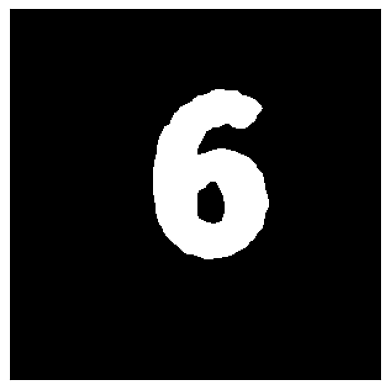

(300, 300)


In [18]:
target_image = processed_boxes[74]
plt.imshow(target_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()
print(target_image.shape)

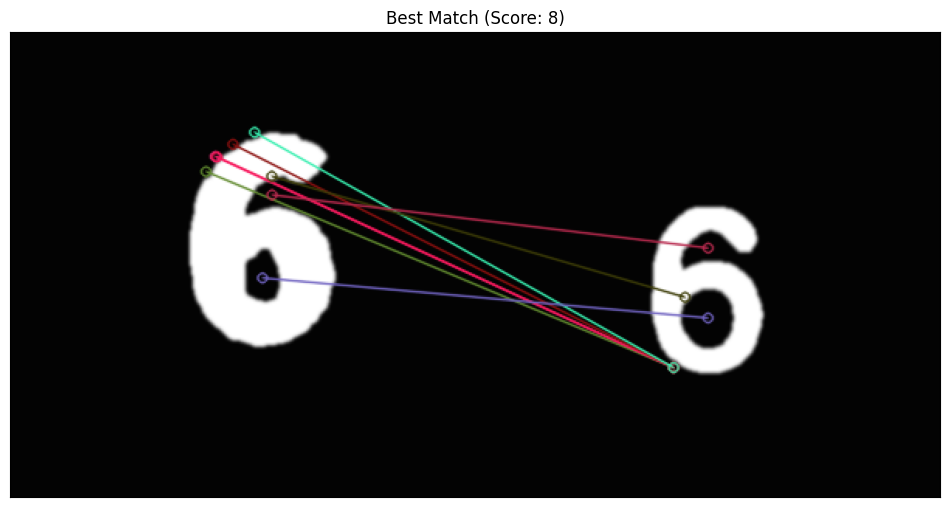

In [19]:
FILE_PATH = './Dataset_Matching/'

# Load target image
# target_image = cv2.resize(target_image, (150, 150))
target_image = cv2.GaussianBlur(target_image, (5, 5), 0)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
target_image = clahe.apply(target_image)

# Initialize SIFT detector
sift = cv2.SIFT_create(nfeatures=1000, contrastThreshold=0.05, edgeThreshold=10, sigma=1.2)

# Detect keypoints and descriptors in target image
target_keypoints, target_descriptors = sift.detectAndCompute(target_image, None)

# Initialize FLANN matcher
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)  # Increase precision
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Tracking best match
best_match_score = 0
best_match_data = {}

# Process dataset images
for sub in os.listdir(FILE_PATH):
    sub_path = os.path.join(FILE_PATH, sub)
    for image_path in os.listdir(sub_path):
        img_path = os.path.join(sub_path, image_path)

        # Load and preprocess dataset image
        image_data = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image_data = cv2.resize(image_data, (300, 300))
        image_data = cv2.GaussianBlur(image_data, (5, 5), 0)
        image_data = clahe.apply(image_data)

        # Detect keypoints and descriptors in dataset image
        img_keypoints, img_descriptors = sift.detectAndCompute(image_data, None)
        if img_descriptors is None:
            continue

        # Match descriptors using FLANN
        matches = flann.knnMatch(target_descriptors, img_descriptors, k=2)

        # Lowe's ratio test
        good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

        # Filter matches using RANSAC
        if len(good_matches) >= 8:
            src_pts = np.float32([target_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([img_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            good_matches = [good_matches[i] for i in range(len(mask)) if mask[i]]

        # Update best match
        current_match_score = len(good_matches)
        if current_match_score > best_match_score:
            best_match_score = current_match_score
            best_match_data = {
                'image_data': image_data,
                'keypoints': img_keypoints,
                'matches': good_matches
            }

# Visualize result
if best_match_data:
    result_image = cv2.drawMatches(
        target_image,
        target_keypoints,
        best_match_data['image_data'],
        best_match_data['keypoints'],
        best_match_data['matches'],
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure(figsize=(12, 8))
    plt.imshow(result_image)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Best Match (Score: {best_match_score})")
    plt.show()
else:
    print("No suitable match found!")

In [20]:
sift = cv2.SIFT_create(nfeatures=1000, contrastThreshold=0.05, edgeThreshold=10, sigma=1.2)

# Initialize FLANN matcher
index_params = dict(algorithm=1, trees=5)  # KDTree
search_params = dict(checks=50)  # Increase precision
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Initialize result matrix (9x9, assuming labels 1-9)
result_matrix = np.zeros((9, 9), dtype=int)

# Function to check if an image is blank (black)
def is_blank(image, threshold=10):
    return np.mean(image) < threshold

# Assuming processed_boxes is a list of images, and you want to match each one
for i, target_image in enumerate(processed_boxes):
    if is_blank(target_image):
        result_matrix[i // 9, i % 9] = 0
        continue
    
    target_image = cv2.resize(target_image, (300, 300))
    target_image = cv2.GaussianBlur(target_image, (5, 5), 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    target_image = clahe.apply(target_image)
    
    
    # Detect keypoints and descriptors in target image
    target_keypoints, target_descriptors = sift.detectAndCompute(target_image, None)

    # Process each image in the dataset
    best_match_score = 0
    best_match_label = 0

    FILE_PATH = './Dataset_Matching/'  # Update with your dataset path

    for sub in os.listdir(FILE_PATH):
        sub_path = os.path.join(FILE_PATH, sub)  # Subfolder label (1-9)
        for image_path in os.listdir(sub_path):
            img_path = os.path.join(sub_path, image_path)

            # Load and preprocess dataset image
            image_data = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            image_data = cv2.resize(image_data, (300, 300))
            image_data = cv2.GaussianBlur(image_data, (5, 5), 0)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            image_data = clahe.apply(image_data)

            # Detect keypoints and descriptors in dataset image
            img_keypoints, img_descriptors = sift.detectAndCompute(image_data, None)
            if img_descriptors is None:
                continue

            # Match descriptors using FLANN
            matches = flann.knnMatch(target_descriptors, img_descriptors, k=2)

            # Lowe's ratio test
            good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

            # Filter matches using RANSAC
            if len(good_matches) >= 8:
                src_pts = np.float32([target_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                dst_pts = np.float32([img_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                good_matches = [good_matches[i] for i in range(len(mask)) if mask[i]]

            # Calculate match score
            current_match_score = len(good_matches)

            # Update best match if current score is higher
            if current_match_score > best_match_score:
                best_match_score = current_match_score
                best_match_label = sub  # The subfolder label (1-9)

    # If a match is found, store the label in the result matrix
    if best_match_score > 0:
        result_matrix[i // 9, i % 9] = int(best_match_label)
    else:
        result_matrix[i // 9, i % 9] = 0

# Display the result matrix
print("Result Matrix:")
print(result_matrix)

Result Matrix:
[[0 8 0 0 0 7 1 7 9]
 [0 0 0 2 0 2 0 6 4]
 [9 0 3 0 0 0 6 0 0]
 [2 1 0 0 6 0 5 0 2]
 [4 0 0 0 5 0 6 1 1]
 [0 0 6 0 4 2 0 0 1]
 [9 0 0 0 0 3 0 0 1]
 [3 5 4 0 1 0 0 3 0]
 [0 3 6 0 2 4 7 0 0]]


In [21]:
sudoku_matrix = result_matrix

# Define a function to check if a number can be placed in the Sudoku grid
def is_valid_move(matrix, row, col, num):
    # Check row
    if num in matrix[row]:
        return False
    # Check column
    if num in matrix[:, col]:
        return False
    # Check 3x3 grid
    start_row, start_col = 3 * (row // 3), 3 * (col // 3)
    if num in matrix[start_row:start_row + 3, start_col:start_col + 3]:
        return False
    return True

# Backtracking function to solve the Sudoku puzzle
def solve_sudoku(matrix):
    for row in range(9):
        for col in range(9):
            if matrix[row, col] == 0:  # Empty cell found
                for num in range(1, 10):  # Numbers 1 to 9
                    if is_valid_move(matrix, row, col, num):
                        matrix[row, col] = num  # Place the number
                        if solve_sudoku(matrix):  # Recursive call
                            return True
                        matrix[row, col] = 0  # Backtrack
                return False  # No valid number found, backtrack
    return True  # Puzzle solved


# Copy the original matrix for displaying later
original_matrix = sudoku_matrix.copy()

# Solve the Sudoku
if solve_sudoku(sudoku_matrix):
    print("Sudoku Solved:")
else:
    print("No solution exists")

# Display the answer matrix
print("Answer Matrix:")
print(sudoku_matrix)

No solution exists
Answer Matrix:
[[0 8 0 0 0 7 1 7 9]
 [0 0 0 2 0 2 0 6 4]
 [9 0 3 0 0 0 6 0 0]
 [2 1 0 0 6 0 5 0 2]
 [4 0 0 0 5 0 6 1 1]
 [0 0 6 0 4 2 0 0 1]
 [9 0 0 0 0 3 0 0 1]
 [3 5 4 0 1 0 0 3 0]
 [0 3 6 0 2 4 7 0 0]]
